Q2. Find top 10 studio with their the revenue ratio every year.

In [2]:
import pandas as pd
import numpy as np
import requests as rq
import sqlite3
from sklearn.preprocessing import OneHotEncoder
from zipfile import ZipFile
import tarfile
import gzip
import matplotlib.pyplot as plt


1. Unzip & import Dataframes

In [3]:
with gzip.open("zippedData/bom.movie_gross.csv.gz", "rb") as f:
    bom_movie_gross = pd.read_csv(f)

with gzip.open("zippedData/tmdb.movies.csv.gz", "rb") as f:
    tmdb_movies = pd.read_csv(f)

with gzip.open("zippedData/tn.movie_budgets.csv.gz", "rb") as f:
    tn_movie_budgets = pd.read_csv(f)


2. Setting Dataframs' index to 'title'

In [4]:
bom_movie_gross.set_index('title', inplace=True)

tn_movie_budgets = tn_movie_budgets.rename(columns={'movie':'title'})
tn_movie_budgets.set_index('title', inplace=True)

tmdb_movies.set_index('title', inplace=True)
tmdb_movies = tmdb_movies.drop(['id', 'Unnamed: 0', 'original_language', 'original_title', 'genre_ids'], axis=1)

3. Join Dataframes

In [5]:
movie_budget = tn_movie_budgets.join(bom_movie_gross, how='outer', rsuffix='_bom')
movie_budget_pop = movie_budget.join(tmdb_movies, how='outer', rsuffix='_pop')

4. Data cleaning

In [6]:
# remove dollar sign
movie_budget_pop.domestic_gross[movie_budget_pop.domestic_gross.str[0] == "$"] = movie_budget_pop.domestic_gross.str[1:]
movie_budget_pop.production_budget[movie_budget_pop.production_budget.str[0] == "$"] = movie_budget_pop.production_budget.str[1:]
movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross.str[0] == "$"] = movie_budget_pop.worldwide_gross.str[1:]


# remove ',' sign
movie_budget_pop['production_budget'] = movie_budget_pop['production_budget'].str.replace(',','', regex=True)
movie_budget_pop['domestic_gross'] = movie_budget_pop['domestic_gross'].str.replace(',','', regex=True)
movie_budget_pop['worldwide_gross'] = movie_budget_pop['worldwide_gross'].str.replace(',','', regex=True)
movie_budget_pop['foreign_gross'] = movie_budget_pop['foreign_gross'].str.replace(',','', regex=True)


# rename studio column values
movie_budget_pop['studio'] = movie_budget_pop['studio'].str.replace('FoxS','Fox', regex=True)
movie_budget_pop['studio'] = movie_budget_pop['studio'].str.replace("WB (NL)","WB", regex=False)


# change 'domestic_gross_bom' type to str
movie_budget_pop['domestic_gross_bom'] = movie_budget_pop['domestic_gross_bom'].astype('str')


# remove .00 from year
movie_budget_pop['year'] = movie_budget_pop['year'].astype('str')
movie_budget_pop.domestic_gross_bom = movie_budget_pop.domestic_gross_bom.str[0:-2]
movie_budget_pop.year = movie_budget_pop.year.str[0:-2]


# fill NaN values
movie_budget_pop['domestic_gross'] = movie_budget_pop['domestic_gross'].fillna(movie_budget_pop['domestic_gross_bom'])
movie_budget_pop['domestic_gross_bom'] = movie_budget_pop['domestic_gross_bom'].fillna(0)
movie_budget_pop.domestic_gross_bom[movie_budget_pop.domestic_gross_bom == "n"] = 0

movie_budget_pop.foreign_gross[movie_budget_pop.foreign_gross.str[-2] == "."] = movie_budget_pop.foreign_gross.str[0:-2]
movie_budget_pop['foreign_gross'] = movie_budget_pop['foreign_gross'].fillna(0)
movie_budget_pop['domestic_gross_bom'] = movie_budget_pop['domestic_gross_bom'].astype('int')
movie_budget_pop['foreign_gross'] = movie_budget_pop['foreign_gross'].astype('int')
movie_budget_pop['new_total'] = movie_budget_pop['domestic_gross_bom'] + movie_budget_pop['foreign_gross']

movie_budget_pop.new_total[movie_budget_pop.new_total == 0] = np.nan
movie_budget_pop['new_total'] = movie_budget_pop['new_total'].astype('str')

movie_budget_pop['worldwide_gross'] = movie_budget_pop['worldwide_gross'].fillna(movie_budget_pop['new_total'])
movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross.str[-2] == "."] = movie_budget_pop.worldwide_gross.str[0:-2]
movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross == '0'] = np.nan
movie_budget_pop.dropna(subset=['production_budget', 'worldwide_gross'], inplace=True)

movie_budget_pop.year[movie_budget_pop.year == "n"] = np.nan
movie_budget_pop['rel_year'] = movie_budget_pop['release_date'].str[-4:]
movie_budget_pop['rel_year2'] = movie_budget_pop['release_date_pop'].str[:4]

movie_budget_pop['year'] = movie_budget_pop['year'].fillna(movie_budget_pop['rel_year'])
movie_budget_pop['year'] = movie_budget_pop['year'].fillna(movie_budget_pop['rel_year2'])
movie_budget_pop['year'] = movie_budget_pop['year'].astype('int')


# drop values
movie_budget_pop = movie_budget_pop.drop(['domestic_gross_bom', 'foreign_gross', 'new_total', 'rel_year', 'release_date', 'id', 'domestic_gross', 'release_date_pop', 'rel_year2'], axis=1)


<ipython-input-6-e48aad986333>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budget_pop.domestic_gross[movie_budget_pop.domestic_gross.str[0] == "$"] = movie_budget_pop.domestic_gross.str[1:]
<ipython-input-6-e48aad986333>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budget_pop.production_budget[movie_budget_pop.production_budget.str[0] == "$"] = movie_budget_pop.production_budget.str[1:]
<ipython-input-6-e48aad986333>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [7]:
# add 'profit_budget_ratio' columns

movie_budget_pop['worldwide_gross'] = movie_budget_pop['worldwide_gross'].astype('float')
movie_budget_pop['production_budget'] = movie_budget_pop['production_budget'].astype('int')
movie_budget_pop['profit_budget_ratio'] = movie_budget_pop['worldwide_gross'] / movie_budget_pop['production_budget']


In [8]:
movie_budget_pop

,production_budget,worldwide_gross,studio,year,popularity,vote_average,vote_count,profit_budget_ratio
title,,,,,,,,
(500) Days of Summer,7500000,34439060.0,NaN,2009,NaN,NaN,NaN,4.591875
10 Cloverfield Lane,5000000,108286422.0,Par.,2016,17.892,6.9,4629.0,21.657284
10 Days in a Madhouse,12000000,14616.0,NaN,2015,0.955,5.4,7.0,0.001218
10 Things I Hate About You,13000000,60413950.0,NaN,1999,NaN,NaN,NaN,4.647227
"10,000 B.C.",105000000,269065678.0,NaN,2008,NaN,NaN,NaN,2.562530
...,...,...,...,...,...,...,...,...
mother!,30000000,42531076.0,Par.,2017,15.227,7.0,3458.0,1.417703
xXx,70000000,267200000.0,NaN,2002,NaN,NaN,NaN,3.817143
xXx: Return of Xander Cage,85000000,345033359.0,NaN,2017,21.749,5.6,2452.0,4.059216


5. Check the relationship between('worldwide_gross', 'production_budget')

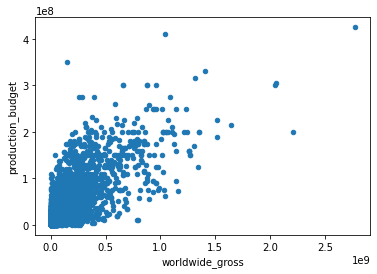

In [9]:
movie_budget_pop.plot.scatter('worldwide_gross', 'production_budget');

6. find average movie budget, profit and profit ratio

In [10]:
average_set = movie_budget_pop.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].mean()

<ipython-input-10-9b2269025376>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_set = movie_budget_pop.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].mean()


In [11]:
average_set

,production_budget,worldwide_gross
year,,
1915,1.100000e+05,1.100000e+07
1916,2.000000e+05,8.000000e+06
1920,1.000000e+05,3.000000e+06
1925,2.072500e+06,1.550000e+07
1929,3.790000e+05,4.358000e+06
...,...,...
2015,3.816529e+07,1.211075e+08
2016,4.395244e+07,1.436871e+08
2017,5.030435e+07,1.855812e+08


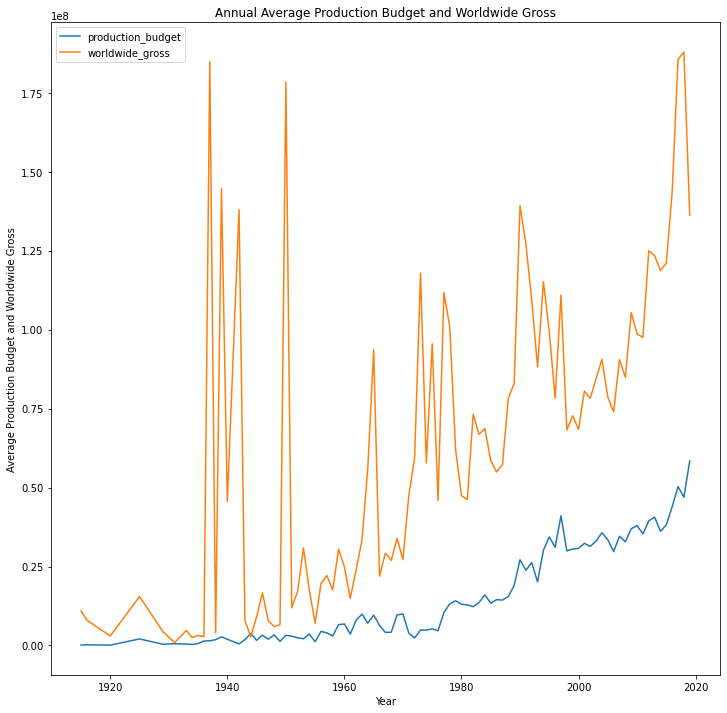

In [11]:
ax = average_set.plot(figsize=(12,12))


ax.set_title('Annual Average Production Budget and Worldwide Gross')
ax.set_xlabel('Year')
ax.set_ylabel('Average Production Budget and Worldwide Gross');

7. make new dataframe without 'studio' NaN values

In [12]:
# drop 'studio' NaN values' rows 
new_set = movie_budget_pop.dropna(subset=['studio'])
new_set = new_set.drop(['vote_count', 'vote_average', 'popularity'], axis=1)
new_set = new_set.drop_duplicates()


In [13]:
# make year_count dataframe by using groupby
year_count = new_set.groupby(['year'], sort=True)['production_budget'].count()
year_sum = new_set.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()
year_sum['count'] = year_count

<ipython-input-13-cdd262f98eb6>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  year_sum = new_set.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()


In [14]:
year_sum

,production_budget,worldwide_gross,count
year,,,
2010,7.153208e+09,1.891124e+10,184
2011,7.263875e+09,2.014082e+10,166
2012,6.712865e+09,2.113732e+10,144
2013,7.224700e+09,2.250815e+10,138
2014,5.799907e+09,2.070279e+10,128
2015,6.690200e+09,2.265549e+10,145
2016,6.860700e+09,2.264705e+10,141
2017,5.877500e+09,2.095622e+10,103
2018,5.003600e+09,2.003832e+10,93


8. Check total production budget, worldwide gross, total number of movies

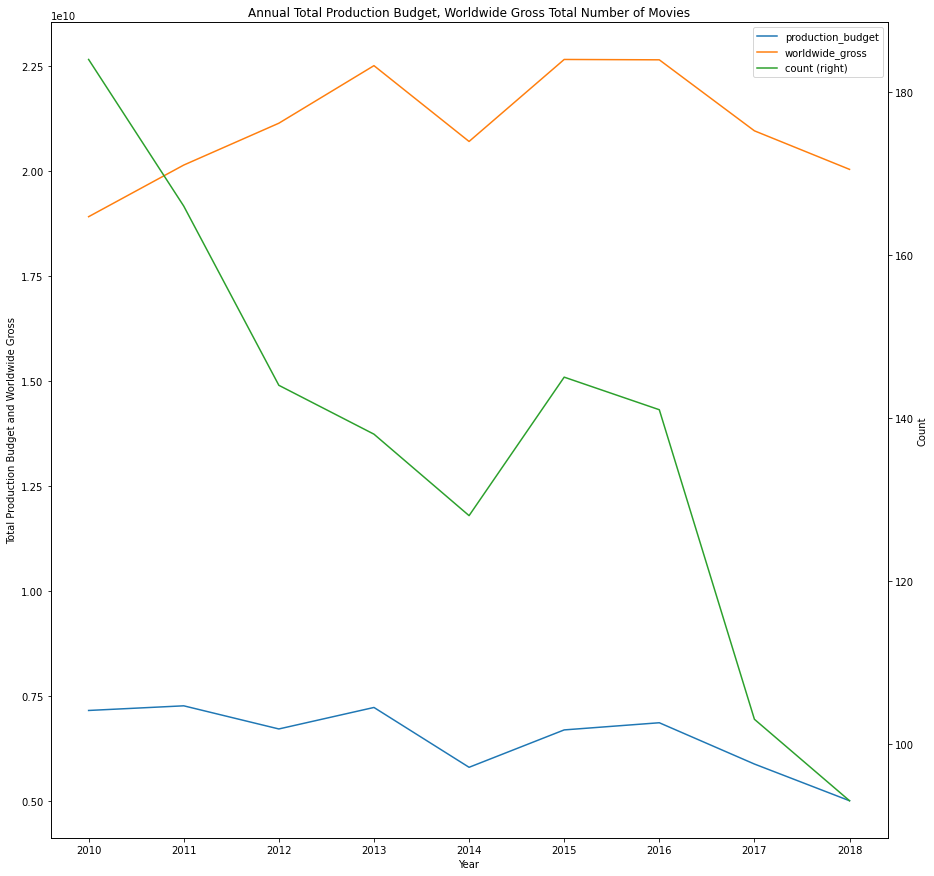

In [15]:
ax = year_sum.plot(figsize=(15,15), secondary_y=['count'])


ax.set_title("Annual Total Production Budget, Worldwide Gross Total Number of Movies")
ax.set_xlabel('Year')
ax.set_ylabel('Total Production Budget and Worldwide Gross')
ax.right_ax.set_ylabel('Count');

9. make dataframe which explain studio's annual data

In [16]:
year_studio_sum = movie_budget_pop.groupby(['studio','year'], sort=True)['production_budget', 'worldwide_gross'].sum()
year_studio_count = movie_budget_pop.groupby(['studio','year'], sort=True)['production_budget'].count()
year_studio_sum['count'] = year_studio_count
year_studio_sum = year_studio_sum.reset_index()
year_studio_sum= year_studio_sum.set_index('year')


<ipython-input-16-b7cb9aabe475>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  year_studio_sum = movie_budget_pop.groupby(['studio','year'], sort=True)['production_budget', 'worldwide_gross'].sum()


In [17]:
# find top 30 worldwide gross of year_studio_sum's studio name
top30_year_studio_sum = year_studio_sum.nlargest(30, ['worldwide_gross'])
list_top30_year_studio_sum = list(set(top30_year_studio_sum['studio']))
print(list_top30_year_studio_sum)

['Par.', 'Uni.', 'WB', 'BV', 'Fox', 'Sony']


Tomorrow's work
- compare major studio's data and non-major studio's data
- find business benchmarking model studio

10. compare major and non-major studio's data

In [18]:
# grouping and cleaning data

movie_budget_pop_2010 = movie_budget_pop[movie_budget_pop['year'] >= 2010]


major_studio_data = movie_budget_pop_2010[movie_budget_pop_2010.studio.isin(list_top30_year_studio_sum)]
major_studio_data = major_studio_data.drop(['vote_count', 'vote_average', 'popularity'], axis=1)
major_studio_data = major_studio_data.drop_duplicates()

major_year_count = major_studio_data.groupby(['year'], sort=True)['production_budget'].count()
major_year_sum = major_studio_data.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].mean()
major_year_sum['count'] = major_year_count



non_major_studio_data = movie_budget_pop_2010[~movie_budget_pop_2010.studio.isin(list_top30_year_studio_sum)]
non_major_studio_data = non_major_studio_data.drop(['vote_count', 'vote_average', 'popularity'], axis=1)
non_major_studio_data = non_major_studio_data.drop_duplicates()


non_major_year_count = non_major_studio_data.groupby(['year'], sort=True)['production_budget'].count()
non_major_year_sum = non_major_studio_data.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].mean()
non_major_year_sum['count'] = non_major_year_count

studio_data = major_year_sum.join(non_major_year_sum, how='outer', lsuffix='_major', rsuffix='_non_major')
studio_data = studio_data.dropna()

<ipython-input-18-82a9c037fa04>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  major_year_sum = major_studio_data.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].mean()
<ipython-input-18-82a9c037fa04>:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  non_major_year_sum = non_major_studio_data.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].mean()


In [19]:
studio_data

,production_budget_major,worldwide_gross_major,count_major,production_budget_non_major,worldwide_gross_non_major,count_non_major
year,,,,,,
2010,6.161649e+07,1.694128e+08,77.0,2.505922e+07,6.399783e+07,184
2011,6.212206e+07,1.725520e+08,85.0,2.275819e+07,6.313255e+07,160
2012,6.863289e+07,2.150882e+08,71.0,2.629120e+07,8.617050e+07,137
2013,8.081884e+07,2.600350e+08,69.0,2.282384e+07,5.921650e+07,142
2014,6.962576e+07,2.617254e+08,66.0,2.084343e+07,5.515015e+07,143
2015,6.520366e+07,2.347809e+08,82.0,2.059192e+07,5.529860e+07,160
2016,7.335714e+07,2.667421e+08,70.0,2.866769e+07,7.492014e+07,134
2017,8.231897e+07,3.092837e+08,58.0,3.262321e+07,9.762638e+07,107
2018,7.676667e+07,3.390491e+08,54.0,3.041250e+07,9.152396e+07,84


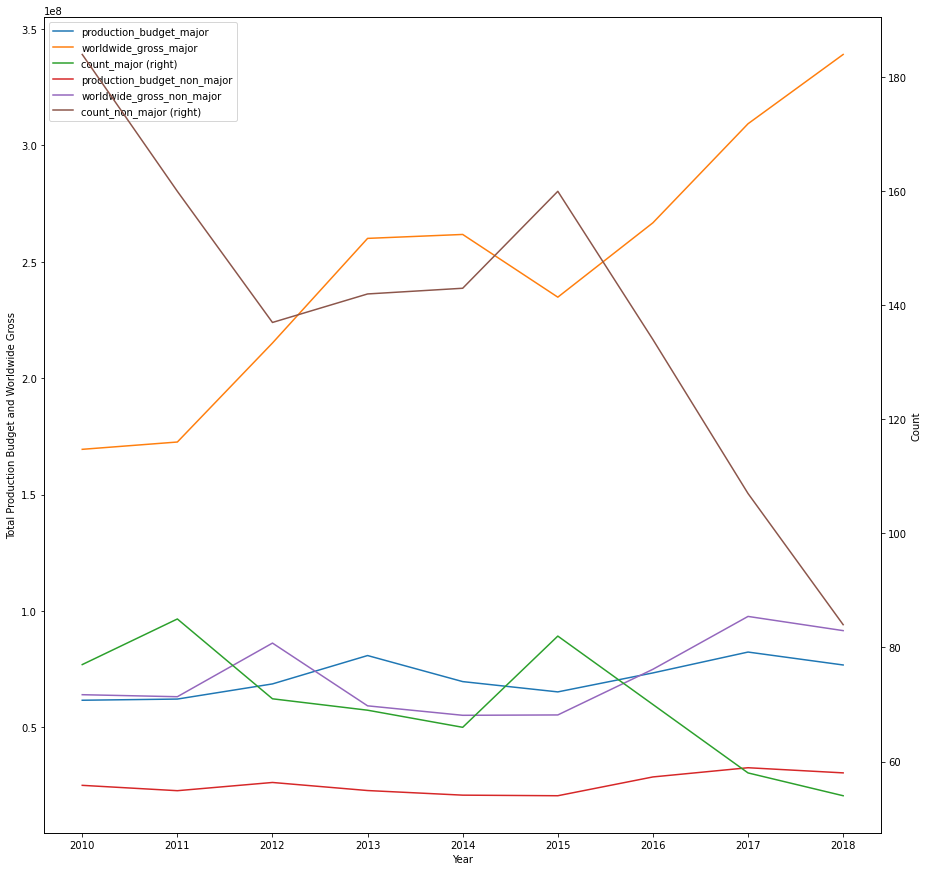

In [20]:
ax = studio_data.plot(figsize=(15,15), secondary_y=['count_major', 'count_non_major'])
ax.set_title = ("Major & Non Major studios' Total Budget, Profit, Counts")
ax.set_xlabel('Year')
ax.set_ylabel('Total Production Budget and Worldwide Gross')
ax.right_ax.set_ylabel('Count');

11. drow plots of top 30 worldwide gross of year_studio_sum's studio data
- Q: how to set secondary yticks, x label of first row

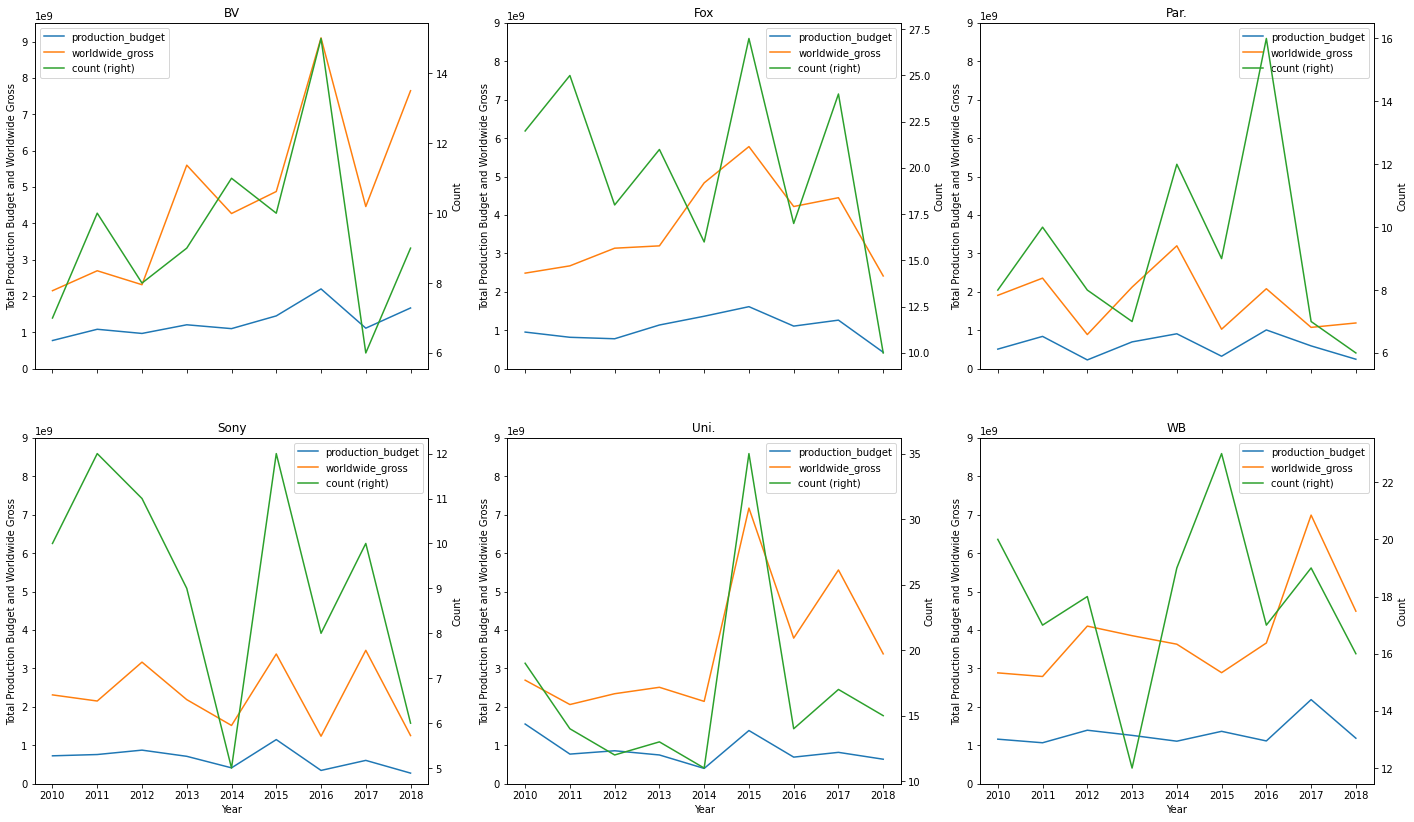

In [21]:
fig, axes = plt.subplots(2,3, figsize=(24,14))


#axes.set_title = ('Top 6 Studio Budget, Profit, Number of Movies')

year_studio_sum[year_studio_sum['studio']=='BV'].plot(ax=axes[0,0], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['count'])
axes[0, 0].set_title('BV')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Total Production Budget and Worldwide Gross')
axes[0, 0].right_ax.set_ylabel('Count')


year_studio_sum[year_studio_sum['studio']=='Fox'].plot(ax=axes[0,1], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['count'])
axes[0, 1].set_title('Fox')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Total Production Budget and Worldwide Gross')
axes[0, 1].right_ax.set_ylabel('Count')


year_studio_sum[year_studio_sum['studio']=='Par.'].plot(ax=axes[0,2], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['count'])
axes[0, 2].set_title('Par.')
axes[0, 2].set_xlabel('Year')
axes[0, 2].set_ylabel('Total Production Budget and Worldwide Gross')
axes[0, 2].right_ax.set_ylabel('Count')


year_studio_sum[year_studio_sum['studio']=='Sony'].plot(ax=axes[1,0], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['count'])
axes[1, 0].set_title('Sony')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Total Production Budget and Worldwide Gross')
axes[1, 0].right_ax.set_ylabel('Count')


year_studio_sum[year_studio_sum['studio']=='Uni.'].plot(ax=axes[1,1], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['count'])
axes[1, 1].set_title('Uni.')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Total Production Budget and Worldwide Gross')
axes[1, 1].right_ax.set_ylabel('Count')


year_studio_sum[year_studio_sum['studio']=='WB'].plot(ax=axes[1,2], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['count'])
axes[1, 2].set_title('WB')
axes[1, 2].set_xlabel('Year')
axes[1, 2].set_ylabel('Total Production Budget and Worldwide Gross')
axes[1, 2].right_ax.set_ylabel('Count');


12. average values of major 6 studios's, period: 9years

In [22]:
year_studio_sum[year_studio_sum['studio'].isin(list_top30_year_studio_sum)].mean().astype(str)

production_budget    962762592.5925926
worldwide_gross      3329389576.703704
count                13.74074074074074
dtype: object